In [2]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from IPython.display import clear_output
import seaborn as sns

%matplotlib inline

In [19]:
mu1, sig1 = [-5., -5.], 1.
mu2, sig2 = [5., 5.], 1.
mu3, sig3 = [-5., 5.], 1.

NOISE_DIM = 2

In [20]:
def get_u(batch_size):
  return torch.rand(batch_size, NOISE_DIM)

def get_n(batch_size):
  return torch.randn(batch_size, 2) + 5

def plot_2d_d(xy):
  cmap = sns.cubehelix_palette(light = 1, as_cmap = True)
  sns.kdeplot(x = xy[:, 0], y = xy[:, 1], cut = 5, label = 'pdata')

def sample_real_data(batch_size):
  n1, n2 = int(batch_size / 3), int(batch_size / 3)
  n3 = batch_size - n1 - n2

  data = np.vstack([np.random.normal(mu1, sig1, (n1, 2)),
                    np.random.normal(mu2, sig2, (n2, 2)),
                    np.random.normal(mu3, sig3, (n3, 2))
                    ])

  return torch.FloatTensor(data)

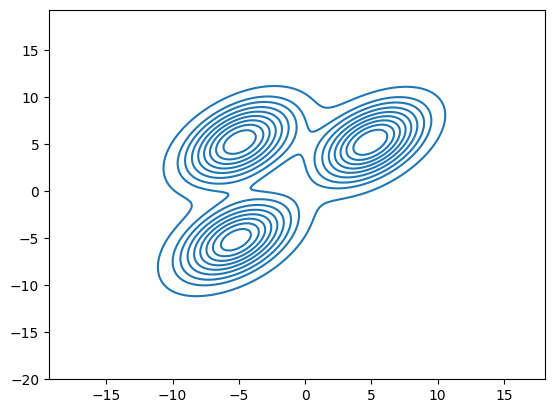

In [21]:
plot_2d_d(sample_real_data(64).data.numpy())

In [22]:
class Generator(nn.Module):
    def __init__(self):
      super().__init__()
      self.main = nn.Sequential(
          nn.Linear(in_features = NOISE_DIM, out_features = 16),
          nn.ReLU(),
          nn.Linear(in_features = 16, out_features = 2)
      )

    def forward(self, x):
      return self.main(x)

class Discriminator(nn.Module):
    def __init__(self):
      super().__init__()
      self.main = nn.Sequential(
          nn.Linear(in_features = 2, out_features = 16),
          nn.ReLU(),
          nn.Linear(in_features = 16, out_features  = 1),
          nn.Sigmoid()
      )

    def forward(self, x):
      return self.main(x)

gen = Generator()
disc = Discriminator()

In [23]:
generator_optm = torch.optim.SGD(gen.parameters(), lr = 1e-3)
discriminator_optm = torch.optim.SGD(disc.parameters(), lr = 1e-3)

In [24]:
def update_D(batch_size):
  real_samples = sample_real_data(batch_size)
  prob_real_is_real = disc(real_samples)

  noise = get_u(batch_size)
  generated_samples = gen(noise)
  prob_fake_is_fake = 1 - disc(generated_samples)

  loss = (-torch.log(prob_real_is_real) - torch.log(prob_fake_is_fake)).mean()

  discriminator_optm.zero_grad()
  loss.backward()
  discriminator_optm.step()

  return loss.data.numpy().item()

In [25]:
def update_G(batch_size):
    noise = get_u(batch_size)
    generated_samples = gen(noise)
    prob_fake_is_real = disc(generated_samples)

    loss = (-torch.log(prob_fake_is_real)).mean()

    generator_optm.zero_grad()
    loss.backward()
    generator_optm.step()

    return loss.data.numpy().item()

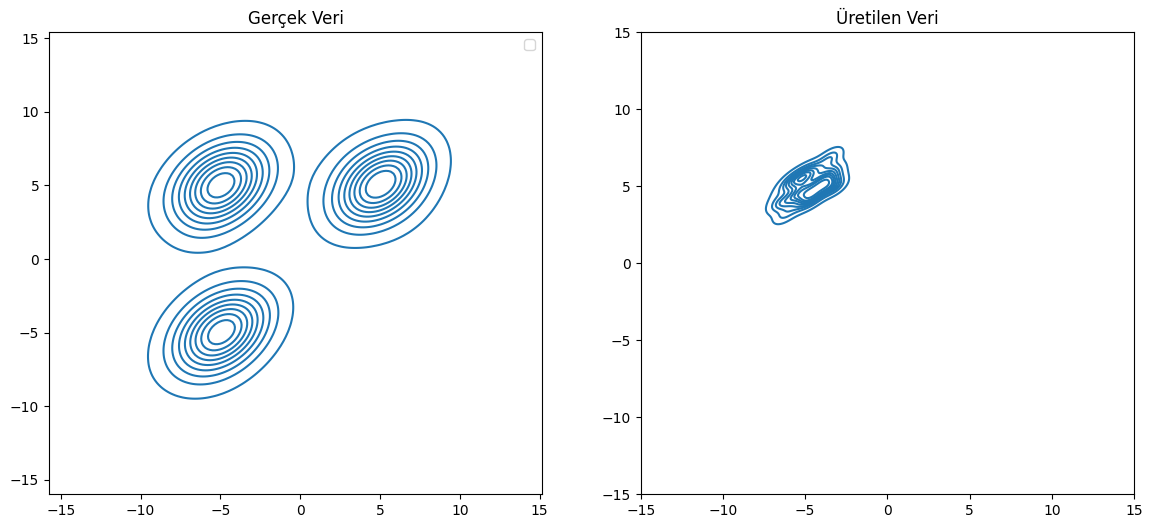

In [26]:
N_DISC_OPERATIONS = 5
BATCH_SIZE = 64

for i in range(10000):
  for _ in range(N_DISC_OPERATIONS):
    update_D(BATCH_SIZE)

  update_G(BATCH_SIZE)

  if i % 300 == 0:
    clear_output(True)
    plt.figure(figsize = [14, 6])
    plt.subplot(1, 2, 1)
    plt.title('Gerçek Veri')
    plot_2d_d(sample_real_data(1000).data.numpy())
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.title('Üretilen Veri')

    plot_2d_d(gen(get_u(100)).data.numpy())

    axes = plt.gca()
    axes.set_ylim([-15, 15])
    axes.set_xlim([-15, 15])

    plt.show()